### Uso de ScikitLearn y modelos de clasificadores basados en caracteres y palabras para hacer el análisis de sentimiento de tweets.

In [1]:
# imports y configuraciones necesarias
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import unicodedata

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josemanuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Cargamos los csv generados con tweets anotados tanto en inglés como español.

Estos datos ya con sentimiento calculado para cada texto, podremos usarlos para entrenar y testear los modelos que generemos para clasificar los tweets por sentimiento.

Los datos del sentimiento vienen con los valores:
Negativo=0,
Neutral=1,
Positivo=2.

In [2]:
# Cargamos los datos en inglés
df_anotados_english = pd.read_csv('./data/df_result_english.csv', sep=',')

print("num_rows: %d\tColumnas: %d\n" % (df_anotados_english.shape[0], df_anotados_english.shape[1]) )
print("Columnas:\n", list(df_anotados_english.columns))

num_rows: 1759315	Columnas: 2

Columnas:
 ['text', 'sentiment']


In [3]:
# los posibles valores vacíos los cambiamos por -1 y los eliminamos, y pasamos los datos de sentimiento a tipo int
df_anotados_english = df_anotados_english.fillna(-1)
df_anotados_english = df_anotados_english[df_anotados_english['sentiment']!=-1]

c_float = df_anotados_english.columns[df_anotados_english.dtypes == float]
df_anotados_english[c_float] = df_anotados_english[c_float].astype(int)

In [4]:
df_anotados_english.head(10)

,text,sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",2
7,@VirginAmerica Really missed a prime opportuni...,1
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",2
9,"@VirginAmerica it was amazing, and arrived an ...",2


In [5]:
# Cargamos los datos en español
df_anotados_spanish = pd.read_csv('./data/df_result_spanish.csv', sep=',')

print("num_rows: %d\tColumnas: %d\n" % (df_anotados_spanish.shape[0], df_anotados_spanish.shape[1]) )
print("Columnas:\n", list(df_anotados_spanish.columns))

num_rows: 48658	Columnas: 2

Columnas:
 ['text', 'sentiment']


In [6]:
df_anotados_spanish.head(10)

,text,sentiment
0,@PauladeLasHeras No te libraras de ayudar me/n...,1
1,@marodriguezb Gracias MAR,2
2,"Off pensando en el regalito Sinde, la que se v...",0
3,Conozco a alguien q es adicto al drama! Ja ja ...,2
4,Toca @crackoviadeTV3 . Grabación dl especial N...,2
5,Buen día todos! Lo primero mandar un abrazo gr...,2
6,Desde el escaño. Todo listo para empezar #endi...,2
7,Bdías. EM no se ira de puente. Si vosotros os ...,2
8,Un sistema económico q recorta dinero para pre...,2
9,#programascambiados caca d ajuste,0


In [7]:
# Vemos los distintos valores que tiene la columna del sentimiento en ambos datasets
print("Recuento valores datos en inglés:",pd.value_counts(df_anotados_english['sentiment']))
print('\n')
print("Recuento valores datos en español:",pd.value_counts(df_anotados_spanish['sentiment']))

Recuento valores datos en inglés: 2    872864
0    871980
1     14470
Name: sentiment, dtype: int64


Recuento valores datos en español: 2    26204
0    19344
1     3110
Name: sentiment, dtype: int64


Como se puede apreciar, ambos datasets tienen un reparto ciertamente similar, aunque con diferencias. Tienen muchos más datos con sentimiento "positivo" y "negativo" (en los datos en inglés el reparto es mucho más equitativo), y muy pocos datos con sentimiento "neutro" en comparación a los otros valores posibles del atributo sentimiento.

El balanceo de los distintos valores posibles del sentimiento en un dataset, influye a la hora de entrenar el modelo, y lo ideal sería tener el mismo reparto.

#### Limpieza de los textos.

Vamos a aplicar a todos los textos de ambos dataframes, técnicas de preprocesado y limpieza de textos, para hacer más efectivos y sencillos los análisis de los textos y la clasificación del sentimiento, y quedarnos en los textos sólo con las palabras que tengan valor para los análisis.

In [8]:
# funciones de preprocesado y limpieza de los textos
def limpiar_tweet(tweet):
    # quitamos RT, @nombre_usuario, links y urls, hashtags, menciones, caracteres extraños o emoticonos
    tweet = re.sub('  +', ' ', tweet)
    # eliminar acentos
    tweet = ''.join((c for c in unicodedata.normalize('NFD', tweet) if unicodedata.category(c) != 'Mn'))  
    # convertir la repetición de una letra más de 2 veces a 1
    # biennnnn --> bien
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    # eliminar "RT", "@usuario", o los enlaces que es información que no sería útil analizar
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub('','',tweet).lower() 
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet)
    tweet = re.sub(r'[0-9]', '', tweet) 

    return tweet 

In [9]:
# como hay muchos datos en inglés, por motivos de eficiencia sacamos un sample de estos datos
df_sample_english = df_anotados_english.sample(frac=0.04, replace=False, random_state=1)

In [10]:
# reparto de valores del atributo sentimiento del sample generado de los datos en inglés
print("Valores dataset:\n",pd.value_counts(df_sample_english['sentiment']))

Valores dataset:
 2    35092
0    34714
1      567
Name: sentiment, dtype: int64


In [11]:
# aplicamos las funciones de limpieza a los textos de ambos dataframes
df_clean_english = df_sample_english.copy()
df_clean_english['text'] = df_clean_english['text'].apply(limpiar_tweet)

df_clean_spanish = df_anotados_spanish.copy()
df_clean_spanish['text'] = df_clean_spanish['text'].apply(limpiar_tweet)

In [12]:
# damos un vistazo a los textos resultantes en español
df_clean_spanish.head(20)

,text,sentiment
0,no te libraras de ayudar me nos besos y gra...,1
1,gracias mar,2
2,off pensando en el regalito sinde la que se v...,0
3,conozco a alguien q es adicto al drama ja ja ...,2
4,toca grabacion dl especial navideno mari ...,2
5,buen dia todos lo primero mandar un abrazo gr...,2
6,desde el escano todo listo para empezar endia...,2
7,bdias em no se ira de puente si vosotros os ...,2
8,un sistema economico q recorta dinero para pre...,2
9,programascambiados caca d ajuste,0


In [13]:
# damos un vistazo a los textos resultantes en inglés
df_clean_english.head(20)

,text,sentiment
128038,seems i always end up at tx schl email lori...,2
491756,yeah don t worry you will there s still ...,0
470925,excited that my email works reliably now with ...,0
491264,yea that s the sad part,0
836490,you let me know i think you too busy for li...,0
371404,well susan didn t make it runner up to...,0
73350,before the cool runs out ima be trying my b...,2
1166160,lmao not today sir sorry sir i did go yester...,2
1070017,loves that lubbock is wet its about time no ...,2
229521,i want a golden retriever puppy soo cute d...,0


Una buena opción para analizar visualmente los datos, es usar wordcloud y pintar una nube de palabras, donde se pueden ver las palabras en relación a su importancia dentro del dataset o conjunto de datos.

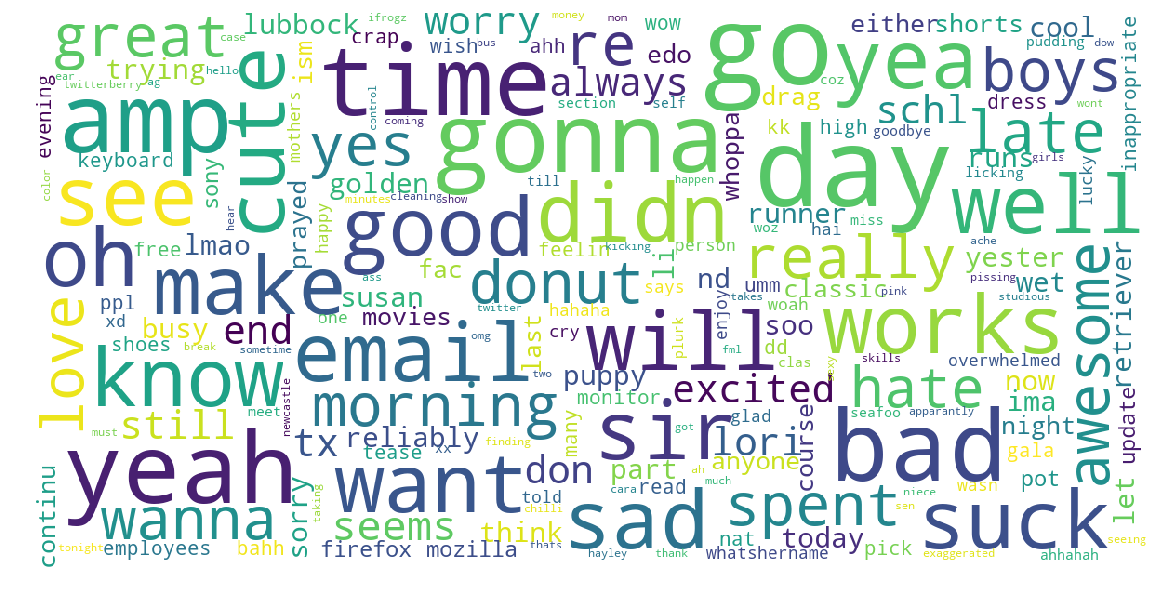

In [14]:
# cargamos las stopwords del módulo para datos en inglés
stopwords_english = set(STOPWORDS)

def show_wordcloud(data, stopwords, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        stopwords = stopwords,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    

# pintamos el wordcloud de los textos en inglés
show_wordcloud(df_clean_english["text"], stopwords_english)

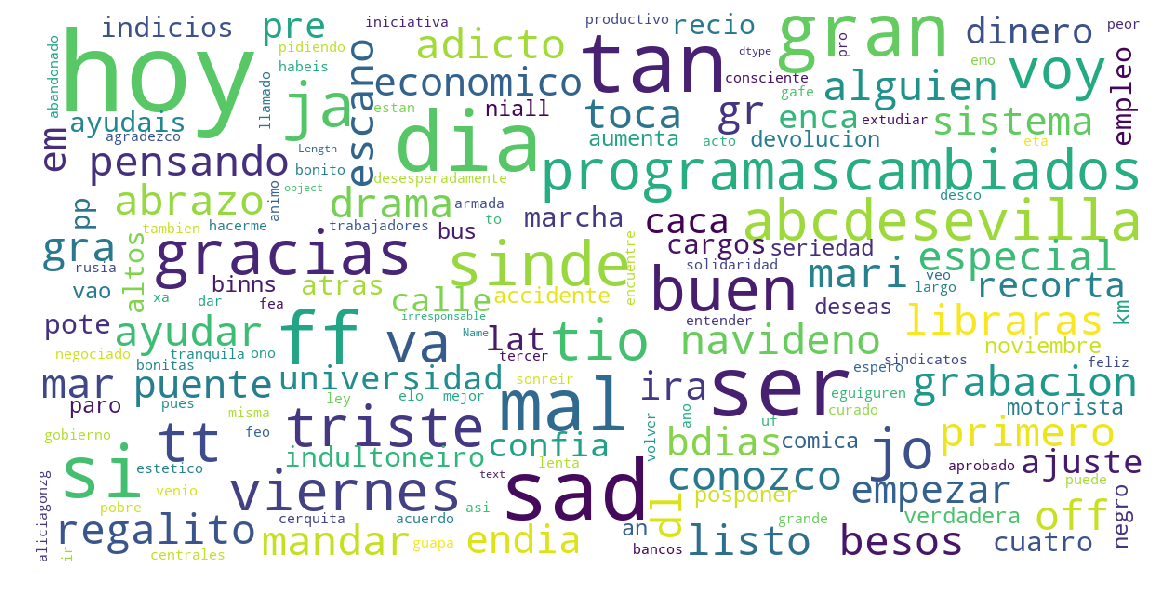

In [15]:
# pintamos el wordcloud de los textos en español
spanish_stopwords = stopwords.words('spanish')

show_wordcloud(df_clean_spanish["text"], spanish_stopwords)

#### Separamos los datos en training y test para los modelos.

Para repartir los datos de cada dataframe entre un conjunto para entrenamiento y otro para testear los modelos, usamos "train_test_split". El reparto se hará en base a un 70% para train, y un 30% para test.

La variable o atributo con la que entrenar y testear sería el texto, y el atributo a predecir o target sería el sentimiento.

In [16]:
# formación de los conjuntos de training y de test para los modelos clasificatorios
X_eng = df_clean_english['text']
y_eng = df_clean_english['sentiment']
X_spa = df_clean_spanish['text']
y_spa = df_clean_spanish['sentiment']

X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)
X_spa_train, X_spa_test, y_spa_train, y_spa_test = train_test_split(X_spa, y_spa, test_size=0.3, random_state=42)

In [17]:
print("Train inglés: %d \t Test inglés: %d" % (len(X_eng_train), len(X_eng_test)))
print("Train español: %d \t Test español: %d" % (len(X_spa_train), len(X_spa_test)))

Train inglés: 49261 	 Test inglés: 21112
Train español: 34060 	 Test español: 14598


#### Modelos.

Vamos a hacer las primeras pruebas con modelos basados en caracteres y en palabras, para tomar las medidas como referencias. 

Primero vamos a construir el modelo basado en caracteres, más sencillo, y en principio se debería obtener mejores resultados con el modelo basado en palabras. Para ambos modelos se monta un proceso donde se convierte el texto dado en un vector de frecuencia de caracteres y de palabras respectivamente, y luego se aplica el sistema de aprendizaje automático sobre los vectores que obtengamos. Para realizar dicha transformación se utiliza la clase "CountVectorizer" del paquete Scikit-Learn.

Esta clase nos da funcionalidad para tomar un listado de textos y convertirlos en una representación numérica. Podemos configurar cómo va a realizarse esta conversión mediante diferentes parámetros a la hora de la instancia.

Para combinar fácilmente este proceso de vectorización con un modelo de clasificación vamos a usar un Pipeline de scikit-learn. "Pipeline" nos permite encadenar varios procesos de modelado, de forma que se ejecuten de forma coordinada.

Aquí vamos a definir un Pipeline que primero aplica la vectorización por frecuencias de caracteres, y después la pasa a un modelo de clasificación tipo SGDClassifier o LinearSVC.

Usamos validación cruzada "GridSearchCV" y así podemos estudiar los mejores parámetros para obtener mejores resultados. Vamos a probar con distintos valores en distintas opciones del clasificador o del vectorizador, y asi mejorar los resultados. Por ejemplo, variando si el modelo se basa en uni-gramas, en bi-gramas, o en tri-gramas.

##### Modelo basado en caracteres.

In [18]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
    ]
)

# Declaración de los parámetros a optimizar automáticamente, y los valores que se probarán para cada uno
params = {
    'classifier__C': [0.001, 0.01, 0.1],
    'vectorizer__analyzer' : ['char'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [19]:
model_eng_char = GridSearchCV(pipeline, params, n_jobs = -1)

# entrenamiento y score del modelo con textos en inglés
model_eng_char.fit(X_eng_train, y_eng_train)
model_eng_char.score(X_eng_test, y_eng_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7550682076544145

In [20]:
# se pueden ver los mejores valores de los parámetros para conseguir la mejor métrica
model_eng_char.best_params_

{'classifier__C': 0.01,
 'vectorizer__analyzer': 'char',
 'vectorizer__ngram_range': (1, 3)}

In [21]:
# entrenamiento y score del modelo con textos en español
model_spa_char = GridSearchCV(pipeline, params, n_jobs = -1)

model_spa_char.fit(X_spa_train, y_spa_train)
model_spa_char.score(X_spa_test, y_spa_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.801068639539663

In [22]:
model_spa_char.best_params_

{'classifier__C': 0.01,
 'vectorizer__analyzer': 'char',
 'vectorizer__ngram_range': (1, 3)}

#### Las distintas medidas para evaluar los modelos:

#### Accuracy (exactitud):
La medida más simple e intuitiva y representa la razón entre las predicciones correctas sobre el total de prediciones realizadas. No es la medida adecuada para evaluar un modelo cuando el problema es desbalanceado al tener datasets con números de elementos de cada clase diferente. Son mejores formas de medir las siguientes medidas.

#### Precisión:
La razón entre el número de documentos clasificados correctamente como pertenecientes a la clase A y el número total de documentos que han sido clasificados por el modelo como de clase A.

#### Recall (exhaustividad):
La relación entre los documentos clasificados correctamente como pertenecientes a la clase A y la suma de todos los documentos de la clase A.

#### F-score:
Se presenta como la media armónica entre las medidas de Precisión y Recall.


En nuestro sistema donde hay más de dos clases, se deben calcular estas medidas para cada clase y luego combinarlas entre ellas para obtener una medida global.

Esto nos lo da el uso del método "classification_report", que nos aporta las distintas combinaciones posibles con Macro-averaging, micro-averaging y weighted-averaging.

Para realmente evaluar cada modelo usaremos los datos que nos de en "weighted-averaging" que es lo más adecuado con un corpus desequilibrado y más de 2 clases distintas del atributo target a predecir.

In [23]:
# predecimos el sentimiento de los datos de test con los modelos anteriores para inglés y español, basados en
# caracteres.
y_pred = model_eng_char.predict(X_eng_test)
y_pred_spa = model_spa_char.predict(X_spa_test)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test, y_pred, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test, y_pred_spa, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     10384
           1       0.92      0.06      0.11       183
           2       0.75      0.78      0.76     10545

   micro avg       0.76      0.76      0.76     21112
   macro avg       0.81      0.53      0.54     21112
weighted avg       0.76      0.76      0.75     21112



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      5785
           1       0.40      0.04      0.08       920
           2       0.82      0.89      0.85      7893

   micro avg       0.80      0.80      0.80     14598
   macro avg       0.67      0.58      0.57     14598
weighted avg       0.78      0.80      0.78     14598



Con el modelo de caracteres si nos fijamos en la métrica "F1_score" y "weighted avg" obtenemos un 75% para el modelo con datos en inglés, y un 78% para el modelo con datos en español.

##### Modelo basado en palabras.

In [24]:
pipeline_word = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
    ]
)

params_word = {
    'classifier__C': [0.001, 0.01, 0.1],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [25]:
model_eng_word = GridSearchCV(pipeline_word, params_word, n_jobs = -1)

# entrenar y testear modelo basado en palabras con textos en inglés
model_eng_word.fit(X_eng_train, y_eng_train)
model_eng_word.score(X_eng_test, y_eng_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7804566123531641

In [26]:
# entrenar y testear modelo basado en palabras con textos en español
model_spa_word = GridSearchCV(pipeline_word, params_word, n_jobs = -1)

model_spa_word.fit(X_spa_train, y_spa_train)
model_spa_word.score(X_spa_test, y_spa_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8324428003836142

In [27]:
# mejores parámetros de los modelos basados en palabras
print("Mejores parámetros modelo datos en inglés: \n", model_eng_word.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_word.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__C': 0.1, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 3)}
Mejores parámetros modelo datos en español: 
 {'classifier__C': 0.1, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}


In [28]:
# predecimos el sentimiento de los datos de test con el modelo anterior, y vemos otras métricas
y_pred_word = model_eng_word.predict(X_eng_test)
y_pred_spa_word = model_spa_word.predict(X_spa_test)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test, y_pred_word, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test, y_pred_spa_word, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.79      0.76      0.78     10384
           1       0.71      0.07      0.12       183
           2       0.77      0.81      0.79     10545

   micro avg       0.78      0.78      0.78     21112
   macro avg       0.76      0.55      0.56     21112
weighted avg       0.78      0.78      0.78     21112



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5785
           1       0.40      0.10      0.16       920
           2       0.85      0.91      0.88      7893

   micro avg       0.83      0.83      0.83     14598
   macro avg       0.69      0.62      0.62     14598
weighted avg       0.81      0.83      0.82     14598



Con el modelo de palabras si nos fijamos en la métrica "F1_score" y "weighted avg" obtenemos un 78% para el modelo con datos en inglés, y un 82% para el modelo con datos en español.

Apreciamos como se obtienen claramente mejores resultados con un modelo basado en palabras, que basado en caracteres.

Ahora vamos a seguir probando el modelo anterior, basado en palabras, con el clasificador de tipo "SGDClassifier".

El clasificador SGDC funciona de forma más rápida y con menos coste computacional que el algoritmo de clasificación LinearSVC.

In [29]:
# Vamos a probar ahora con SGDClassifier
pipeline_sgdc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SGDClassifier())
    ]
)

params_sgdc = {
    'classifier__alpha': [0.001, 0.01, 0.1],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [30]:
model_eng_sgdc = GridSearchCV(pipeline_sgdc, params_sgdc, n_jobs = -1)

# entrenar y testear el modelo con clasificador SGDC con textos en inglés
model_eng_sgdc.fit(X_eng_train, y_eng_train)
model_eng_sgdc.score(X_eng_test, y_eng_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.769893899204244

In [31]:
# entrenar y testear el modelo con clasificador SGDC con datos en español
model_spa_sgdc = GridSearchCV(pipeline_sgdc, params_sgdc, n_jobs = -1)

model_spa_sgdc.fit(X_spa_train, y_spa_train)
model_spa_sgdc.score(X_spa_test, y_spa_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.8202493492259214

In [32]:
# mejores parámetros
print("Mejores parámetros modelo datos en inglés: \n", model_eng_sgdc.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_sgdc.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__alpha': 0.001, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 3)}
Mejores parámetros modelo datos en español: 
 {'classifier__alpha': 0.001, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 2)}


In [33]:
y_pred_sgdc = model_eng_sgdc.predict(X_eng_test)
y_pred_spa_sgdc = model_spa_sgdc.predict(X_spa_test)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test, y_pred_sgdc, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test, y_pred_spa_sgdc, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     10384
           1       0.60      0.02      0.03       183
           2       0.76      0.81      0.78     10545

   micro avg       0.77      0.77      0.77     21112
   macro avg       0.71      0.52      0.53     21112
weighted avg       0.77      0.77      0.77     21112



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      5785
           1       0.56      0.03      0.05       920
           2       0.84      0.91      0.87      7893

   micro avg       0.82      0.82      0.82     14598
   macro avg       0.73      0.59      0.58     14598
weighted avg       0.80      0.82      0.80     14598



Se obtienen ligeramente peores resultados al utilizar el clasificador SGDClassifier, pero a cambio se ejecuta con bastante mayor velocidad.

Para estas pruebas seguiremos usando este clasificador, y cuando probemos finalmente los clasificadores para ver que modelo puede funcionar mejor volveremos a usar LinearSVC.

Vamos a probar añadiendo a nuestro pipeline el uso de "TF-IDF" además del clasificador y el vectorizador.

Term Frequency - Inverse Document Frequency (tf-idf) es una técnica similar a bag-of-words, pero en la que se pesan cada una de las palabras o tokens según la relevancia que parezcan tener en el texto analizado. Esta relevancia se calcula según el número de veces que la palabra aparece en el documento (Term Frequency) dividido por el número de documentos del corpus en los que aparece ese mismo término (Inverse Document Frequency). Esto nos permite reducir la importancia que tendrán en nuestro modelo las palabras generales del idioma que aparecen en casi todos los documentos (stop-words), centrándonos en palabras más distintivas de cada texto. En scikit-learn el vectorizador de textos mediante tf-idf es la clase TfidfVectorizer.

In [34]:
# montamos el pipeline con el uso de TFIDF y entrenamos y evaluamos los dos modelos como anteriormente hemos hecho
pipeline_tfidf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier())
    ]
)
    
params_tfidf = {
    'classifier__alpha': [0.001, 0.01, 0.1],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [35]:
model_eng_tfidf = GridSearchCV(pipeline_tfidf, params_tfidf, n_jobs = -1, cv=5)

# entrenar y testear el modelo usando TFIDF con textos en inglés
model_eng_tfidf.fit(X_eng_train, y_eng_train)
model_eng_tfidf.score(X_eng_test, y_eng_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7344164456233422

In [36]:
model_spa_tfidf = GridSearchCV(pipeline_tfidf, params_tfidf, n_jobs = -1, cv=5)

# entrenar y testear el modelo usando TFIDF con textos en español
model_spa_tfidf.fit(X_spa_train, y_spa_train)
model_spa_tfidf.score(X_spa_test, y_spa_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7498287436635156

In [37]:
# mejores parámetros
print("Mejores parámetros modelo datos en inglés: \n", model_eng_tfidf.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_tfidf.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
Mejores parámetros modelo datos en español: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}


In [38]:
y_pred_tfidf = model_eng_tfidf.predict(X_eng_test)
y_pred_spa_tfidf = model_spa_tfidf.predict(X_spa_test)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test, y_pred_tfidf, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test, y_pred_spa_tfidf, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.74      0.73      0.73     10384
           1       0.00      0.00      0.00       183
           2       0.73      0.75      0.74     10545

   micro avg       0.73      0.73      0.73     21112
   macro avg       0.49      0.49      0.49     21112
weighted avg       0.73      0.73      0.73     21112



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.77      0.65      0.71      5785
           1       0.00      0.00      0.00       920
           2       0.74      0.91      0.82      7893

   micro avg       0.75      0.75      0.75     14598
   macro avg       0.50      0.52      0.51     14598
weighted avg       0.71      0.75      0.72     14598



/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Al introducir el uso de TF-IDF se obtienen peores resultados. Se ha probado con el transformador TF-IDF, más adelante también se probará a usar TF-IDF pero como vectorizador, en lugar de CountVectorizer.

Como hemos indicado, es posible utilizar alternativas al método CountVectorizer que hemos estado empleando hasta ahora. Mientras que CountVectorizer esencialmente implementa una estrategia de "bag-of-words" para generar un vector que represente el texto, es posible también utilizar estrategias basadas en el "hashing trick".

In [39]:
# probar con hashingVectorizer en lugar de countVectorizer
pipeline_hash = Pipeline([
    ('vectorizer', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier())
    ]
)
    
params_hash = {
    'classifier__alpha': [0.001, 0.01, 0.1],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [40]:
model_eng_hash = GridSearchCV(pipeline_hash, params_hash, n_jobs = -1, cv=5)

# entrenar y testear el modelo con vectorizador Hashing con textos en inglés
model_eng_hash.fit(X_eng_train, y_eng_train)
model_eng_hash.score(X_eng_test, y_eng_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7343217127699886

In [41]:
model_spa_hash = GridSearchCV(pipeline_hash, params_hash, n_jobs = -1, cv=5)

# entrenar y testear el modelo con vectorizador Hashing con textos en español
model_spa_hash.fit(X_spa_train, y_spa_train)
model_spa_hash.score(X_spa_test, y_spa_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7435950130154816

In [42]:
# mejores parámetros
print("Mejores parámetros modelo datos en inglés: \n", model_eng_hash.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_hash.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
Mejores parámetros modelo datos en español: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}


In [43]:
y_pred_hash = model_eng_hash.predict(X_eng_test)
y_pred_spa_hash = model_spa_hash.predict(X_spa_test)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test, y_pred_hash, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test, y_pred_spa_hash, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.74      0.72      0.73     10384
           1       0.00      0.00      0.00       183
           2       0.72      0.76      0.74     10545

   micro avg       0.73      0.73      0.73     21112
   macro avg       0.49      0.49      0.49     21112
weighted avg       0.73      0.73      0.73     21112



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      5785
           1       0.00      0.00      0.00       920
           2       0.73      0.92      0.81      7893

   micro avg       0.74      0.74      0.74     14598
   macro avg       0.50      0.51      0.50     14598
weighted avg       0.70      0.74      0.71     14598



/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Al cambiar el vectorizador a tipo HashingVectorizer se obtienen prácticamente los mismos resultados, aunque ligeramente peores con el modelo de datos en español.

Seguiremos usando CountVectorizer a partir de ahora.

Vamos a probar el modelo usando un mayor % de datos de cada dataset como datos de training (90% train, 10% test), por si tiene algún impacto en los resultados que se obtienen. 

Al probar con un conjunto relativamente pequeño de datos, es más recomendable repartir los datos con mayor porcentaje para el conjunto de entrenamiento.

In [44]:
# formación de los conjuntos de training y de test para los modelos clasificatorios
X_eng_train_2, X_eng_test_2, y_eng_train_2, y_eng_test_2 = \
        train_test_split(X_eng, y_eng, test_size=0.1, random_state=42)
X_spa_train_2, X_spa_test_2, y_spa_train_2, y_spa_test_2 = \
        train_test_split(X_spa, y_spa, test_size=0.1, random_state=42)

print("Train inglés: %d \t Test inglés: %d" % (len(X_eng_train_2), len(X_eng_test_2)))
print("Train español: %d \t Test español: %d" % (len(X_spa_train_2), len(X_spa_test_2)))

Train inglés: 63335 	 Test inglés: 7038
Train español: 43792 	 Test español: 4866


In [56]:
pipeline_final = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier())
    ]
)
    
params_final = {
    'classifier__alpha': [0.001, 0.01, 0.1],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [57]:
model_eng_final = GridSearchCV(pipeline_final, params_final, n_jobs = -1, cv=5)

model_eng_final.fit(X_eng_train_2, y_eng_train_2)
model_eng_final.score(X_eng_test_2, y_eng_test_2)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7280477408354646

In [58]:
model_spa_final = GridSearchCV(pipeline_final, params_final, n_jobs = -1, cv=5)

model_spa_final.fit(X_spa_train_2, y_spa_train_2)
model_spa_final.score(X_spa_test_2, y_spa_test_2)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7529798602548294

In [59]:
# mejores parámetros
print("Mejores parámetros modelo datos en inglés: \n", model_eng_final.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_final.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
Mejores parámetros modelo datos en español: 
 {'classifier__alpha': 0.001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}


In [60]:
y_pred_final = model_eng_final.predict(X_eng_test_2)
y_pred_spa_final = model_spa_final.predict(X_spa_test_2)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test_2, y_pred_final, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test_2, y_pred_spa_final, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      3497
           1       0.00      0.00      0.00        62
           2       0.72      0.74      0.73      3479

   micro avg       0.73      0.73      0.73      7038
   macro avg       0.49      0.49      0.49      7038
weighted avg       0.72      0.73      0.72      7038



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1881
           1       0.00      0.00      0.00       310
           2       0.74      0.92      0.82      2675

   micro avg       0.75      0.75      0.75      4866
   macro avg       0.51      0.52      0.51      4866
weighted avg       0.71      0.75      0.72      4866



/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Ahora probamos con unos cambios de parámetros: uso de tokenizer o stratifiedKFold, para ver si obtenemos alguna mejora final de las medidas evaluadas.

La tokenización es el proceso de demarcación y posible clasificación de secciones de una cadena de caracteres de entrada. Los tokens resultantes se pasan a alguna otra forma de procesamiento.

StratifiedKFold es un validador cruzado que proporciona índices de train/test para la división de los datos en los conjuntos de entrenamiento y testeo. Los pliegues se realizan conservando el porcentaje de muestras para cada clase.

In [50]:
tokenizer = TweetTokenizer().tokenize
    
skf = StratifiedKFold(n_splits=10, shuffle=True)

Volvemos a usar el vectorizador "CountVectorizer" que daba mejores resultados que "HashingVectorizer", y eliminamos el uso del transformador TF-IDF. Posteriormente probaremos con el vectorizador TF-IDF.

In [51]:
pipeline_final_2 = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer)),
    ('classifier', SGDClassifier())
    ]
)
    
params_final_2 = {
    'classifier__alpha': [0.001, 0.01, 0.1],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

In [52]:
model_eng_final_2 = GridSearchCV(pipeline_final_2, params_final_2, n_jobs = -1, cv=skf, refit='f1_weighted')

model_eng_final_2.fit(X_eng_train_2, y_eng_train_2)
model_eng_final_2.score(X_eng_test_2, y_eng_test_2)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.770105143506678

In [53]:
model_spa_final_2 = GridSearchCV(pipeline_final_2, params_final_2, n_jobs = -1, cv=skf)

model_spa_final_2.fit(X_spa_train_2, y_spa_train_2)
model_spa_final_2.score(X_spa_test_2, y_spa_test_2)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.8185367858610768

In [54]:
# mejores parámetros
print("Mejores parámetros modelo datos en inglés: \n", model_eng_final_2.best_params_)
print("Mejores parámetros modelo datos en español: \n", model_spa_final_2.best_params_)

Mejores parámetros modelo datos en inglés: 
 {'classifier__alpha': 0.001, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 3)}
Mejores parámetros modelo datos en español: 
 {'classifier__alpha': 0.001, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 3)}


In [55]:
y_pred_final_2 = model_eng_final_2.predict(X_eng_test_2)
y_pred_spa_final_2 = model_spa_final_2.predict(X_spa_test_2)

print("Métricas modelo con datos en inglés:\n")
print(classification_report(y_eng_test_2, y_pred_final_2, target_names=None))
print("\n")
print("Métricas modelo con datos en español:\n")
print(classification_report(y_spa_test_2, y_pred_spa_final_2, target_names=None))

Métricas modelo con datos en inglés:

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      3497
           1       1.00      0.03      0.06        62
           2       0.75      0.81      0.78      3479

   micro avg       0.77      0.77      0.77      7038
   macro avg       0.85      0.53      0.54      7038
weighted avg       0.77      0.77      0.77      7038



Métricas modelo con datos en español:

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1881
           1       0.58      0.05      0.09       310
           2       0.82      0.93      0.87      2675

   micro avg       0.82      0.82      0.82      4866
   macro avg       0.74      0.59      0.59      4866
weighted avg       0.80      0.82      0.80      4866



Con las pruebas realizadas parece que los mejores resultados se obtienen con el uso del algoritmo de clasificación LinearSVC. Por norma general se obtienen ligeramente mejores resultados con los datos en español que con los datos en inglés, puede ser debido a los datos en sí.

Obviamente para obtener mejores resultados se pueden usar muchos parámetros con distintos valores, y se podría seguir profundizando en los modelos y llegar a obtener mejores resultados. Pero por razones de tiempo y de coste computacional que supondría no se entra en mayor profundidad.

Con algunas de las pautas de estas pruebas lanzaremos una prueba final de un modelo con algunos de los clasificadores más habituales para finalmente quedarnos con uno y aplicarlo en el streaming.
